In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import os
import glob
from collections import Counter

In [28]:
import sklearn
print(sklearn.__version__)


1.6.1


In [ ]:
# 1 s windows with 50% overlap. Label with majority class. Rule = remove windows that don't have 90% same majority
def create_sliding_windows(df, window_length=1, stepsize=0.5):
    # initialize
    windows = [] # to save output
    start = df['Time'].min()
    end_time = df['Time'].max()

    while start + window_length <= end_time:
        end = start + window_length
        # create df per window
        window_df = df[(df['Time'] >= start) & (df['Time'] <= end)]

        # define majority event label
        labels = window_df['GeneralEvent'].tolist()
        label_counts = Counter(labels) # keeps count of elements in an iterable
        top_label, top_count = label_counts.most_common(1)[0]
        percentage = top_count/len(labels)

        # if 90% of same event label, keep window, add to output
        if percentage >= 0.95:
            windows.append({
                'start': start,
                'end': end,
                'label': top_label,
                'row indices': window_df.index.tolist()
            })

        # slide window
        start += stepsize

    return windows


In [ ]:
def feature_extraction(df, participant_id, windows, features):
    output_rows = []

    for i, window in enumerate(windows):
        window_data = df.loc[window['row indices'],features] # defines what data is in each window

        # define rows via dictionary
        row = {
        'Participant': f'{participant_id}',
        'Window': i + 1,
        'GeneralEvent': window['label'] }

        # add to dictionary, column-specific operations
        for col in features:  # computing for every column, which separates X,Y,Z
            data = window_data[col]
            row[f'{col}_mean'] = data.mean()
            row[f'{col}_std'] = data.std()
            row[f'{col}_max'] = data.max()
            row[f'{col}_min'] = data.min()
            row[f'{col}_rms'] = np.sqrt(np.mean(np.square(data)))

            # peak counts and zero crossing require variable is oscilliatory: FreeAcc and Gyr only
            names = ['FreeAcc', 'Gyr']
            if any(name in col for name in names): # check if any substring in col matches either of the strings in name
                row[f'{col}_zerocross'] = ((data[:-1] * data[1:]) < 0).sum() # el-wise product of consecutive pairs. # num < 0 = # zerocross
                peaks, properties = find_peaks(data)
                row[f'{col}_peakcount'] = len(peaks) # peak count

        output_rows.append(row) # add to output
        features_df = pd.DataFrame(output_rows)

    return features_df

In [ ]:
def preprocess(df, participant_id):

    # remove columns with NA
    df.dropna(axis=1, inplace=True)

    # fix Time data type
    df['Time'] = df['Time'].str.replace(" sec", "").astype(float)

    # create sliding windows
    windows = create_sliding_windows(df)

    # feature engineering per window
    # identify cols
    names = ['FreeAcc', 'Gyr', 'VelInc', 'Roll', 'Pitch', 'Yaw']
    chosen_variables = []

    for col in df.columns.tolist():
        for n in names:
            if n in col:
                chosen_variables.append(col)
    # extract feats
    wf_df = feature_extraction(df, participant_id, windows, chosen_variables)

    return wf_df

In [ ]:
def get_pt_id(file_path):
    # get filename
    filename = os.path.basename(file_path)
    # split string, get all before '_tug'
    participant_id = filename.split('_tug')[0]
    return participant_id

In [ ]:
# read in files from csv
csv_folder = r"C:\Users\sabin\OneDrive\Desktop\ML Wearables Project\synapse_data"
csv_folder_PD = r"C:\Users\sabin\OneDrive\Desktop\ML Wearables Project\synapse_data_PD"

# 2. Get list of all CSV files in that folder
csv_files = glob.glob(os.path.join(csv_folder, '*.csv')) # 65 files
csv_files_PD = glob.glob(os.path.join(csv_folder_PD, '*.csv')) # 61
all_files = csv_files + csv_files_PD

In [ ]:
# create list of all pre-processed dfs
processed_dfs = []
for file in all_files: # chnaged from all_files
    df = pd.read_csv(file)
    participant_id = get_pt_id(file)
    wf_df = preprocess(df, participant_id)
    processed_dfs.append(wf_df)

# # create DataFrame out of list of pre-processed dfs
df = pd.concat(processed_dfs, ignore_index=True)

In [ ]:
#df = pd.concat((NC_df, PD_df), axis=0, ignore_index=True) # stack NC and PD dataframes

In [8]:
df = pd.read_csv('/content/preprocessed_df.csv')

In [9]:
df.shape

(10281, 939)

In [10]:
len(np.unique(df['Participant']))

126

In [ ]:
# now check for NaN
# count = 0
# for col in df.columns.tolist():
#     if df[col].isna().sum() > 0:
#         print(f'{col}: {df[col].isna().sum()}')
#         count += 1
# print(count)

# ranges from 100-527 rows with NA.. drop rows with NA.. still will have 10K rows

# in the future, don't use inplace=True bc takes a long time to load data

In [11]:
dff = df.dropna(axis=0) # drop rows with NA

In [12]:
len(np.unique(dff['Participant'])) # drops 23 participants

103

In [13]:
# drop rows where Event = 'unlabeled'
df_clean = dff[dff['GeneralEvent'] != 'unlabeled']

# Revisit Handling of NA: drop rows or drop cols
## lost 23 participants dropping by row
## lost 2K rows dropping by row

In [14]:
df_clean

,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,LowerBack_FreeAcc_E_peakcount,...,Forehead_Pitch_mean,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms
0,HC127,1,Sitting,0.039422,0.026305,0.090083,-0.042820,0.047320,0.0,32.0,...,0.937011,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570
1,HC127,2,Sitting,0.038468,0.024624,0.110037,-0.042820,0.045608,0.0,32.0,...,0.724209,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811
2,HC127,3,Sitting,0.038304,0.018826,0.110037,-0.008691,0.042639,0.0,33.0,...,0.614142,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758
3,HC127,4,Sitting,0.039163,0.019854,0.089022,-0.005469,0.043863,0.0,36.0,...,0.347224,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843
4,HC127,5,Sitting,0.039559,0.021399,0.093039,-0.013712,0.044925,0.0,34.0,...,0.048113,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NLS022,61,Sitting,0.044224,0.031367,0.121560,-0.037111,0.054129,0.0,30.0,...,0.184778,0.181484,0.539548,-0.169947,0.258366,-143.096121,3.536851,-136.907151,-146.082444,143.139391
10277,NLS022,62,Sitting,0.017734,0.027936,0.089327,-0.037618,0.032972,0.0,29.0,...,0.338675,0.184555,0.539548,-0.040658,0.385258,-138.063167,3.276524,-134.448461,-145.395194,138.101656
10278,NLS022,63,Sitting,-0.004072,0.025544,0.064759,-0.057539,0.025741,0.0,29.0,...,0.570566,0.280925,1.159762,0.288697,0.635361,-133.045931,3.464658,-125.049828,-136.907151,133.090588
10279,NLS022,64,Sitting,-0.018309,0.050238,0.146274,-0.168325,0.053237,0.0,27.0,...,1.341241,0.776763,2.532875,0.337477,1.548004,-126.274312,4.744236,-121.087059,-134.448461,126.362522


In [15]:
df_clean = df_clean.reset_index()
df_clean

,index,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,...,Forehead_Pitch_mean,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms
0,0,HC127,1,Sitting,0.039422,0.026305,0.090083,-0.042820,0.047320,0.0,...,0.937011,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570
1,1,HC127,2,Sitting,0.038468,0.024624,0.110037,-0.042820,0.045608,0.0,...,0.724209,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811
2,2,HC127,3,Sitting,0.038304,0.018826,0.110037,-0.008691,0.042639,0.0,...,0.614142,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758
3,3,HC127,4,Sitting,0.039163,0.019854,0.089022,-0.005469,0.043863,0.0,...,0.347224,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843
4,4,HC127,5,Sitting,0.039559,0.021399,0.093039,-0.013712,0.044925,0.0,...,0.048113,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,10276,NLS022,61,Sitting,0.044224,0.031367,0.121560,-0.037111,0.054129,0.0,...,0.184778,0.181484,0.539548,-0.169947,0.258366,-143.096121,3.536851,-136.907151,-146.082444,143.139391
8231,10277,NLS022,62,Sitting,0.017734,0.027936,0.089327,-0.037618,0.032972,0.0,...,0.338675,0.184555,0.539548,-0.040658,0.385258,-138.063167,3.276524,-134.448461,-145.395194,138.101656
8232,10278,NLS022,63,Sitting,-0.004072,0.025544,0.064759,-0.057539,0.025741,0.0,...,0.570566,0.280925,1.159762,0.288697,0.635361,-133.045931,3.464658,-125.049828,-136.907151,133.090588
8233,10279,NLS022,64,Sitting,-0.018309,0.050238,0.146274,-0.168325,0.053237,0.0,...,1.341241,0.776763,2.532875,0.337477,1.548004,-126.274312,4.744236,-121.087059,-134.448461,126.362522


In [16]:
# Add label: normal control or PD

df_clean['Diagnosis'] = df_clean['Participant'].astype(str).apply(
    lambda x: 0 if x.startswith(("hc", "whc")) else 1) # 0 for NC 1 for PD

In [17]:
df_clean = df_clean.copy()

In [18]:
df_clean.head()

,index,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,...,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms,Diagnosis
0,0,HC127,1,Sitting,0.039422,0.026305,0.090083,-0.042820,0.047320,0.0,...,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570,1
1,1,HC127,2,Sitting,0.038468,0.024624,0.110037,-0.042820,0.045608,0.0,...,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811,1
2,2,HC127,3,Sitting,0.038304,0.018826,0.110037,-0.008691,0.042639,0.0,...,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758,1
3,3,HC127,4,Sitting,0.039163,0.019854,0.089022,-0.005469,0.043863,0.0,...,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843,1
4,4,HC127,5,Sitting,0.039559,0.021399,0.093039,-0.013712,0.044925,0.0,...,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069,1


In [21]:
df_clean.iloc[:,4:-1]

,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,LowerBack_FreeAcc_E_peakcount,LowerBack_FreeAcc_N_mean,LowerBack_FreeAcc_N_std,LowerBack_FreeAcc_N_max,...,Forehead_Pitch_mean,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms
0,0.039422,0.026305,0.090083,-0.042820,0.047320,0.0,32.0,-0.001104,0.024406,0.051831,...,0.937011,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570
1,0.038468,0.024624,0.110037,-0.042820,0.045608,0.0,32.0,-0.004288,0.025047,0.051831,...,0.724209,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811
2,0.038304,0.018826,0.110037,-0.008691,0.042639,0.0,33.0,-0.005689,0.019059,0.030665,...,0.614142,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758
3,0.039163,0.019854,0.089022,-0.005469,0.043863,0.0,36.0,-0.003516,0.018023,0.030408,...,0.347224,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843
4,0.039559,0.021399,0.093039,-0.013712,0.044925,0.0,34.0,-0.003159,0.019035,0.031654,...,0.048113,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0.044224,0.031367,0.121560,-0.037111,0.054129,0.0,30.0,0.014393,0.021798,0.060970,...,0.184778,0.181484,0.539548,-0.169947,0.258366,-143.096121,3.536851,-136.907151,-146.082444,143.139391
8231,0.017734,0.027936,0.089327,-0.037618,0.032972,0.0,29.0,0.008887,0.018049,0.063843,...,0.338675,0.184555,0.539548,-0.040658,0.385258,-138.063167,3.276524,-134.448461,-145.395194,138.101656
8232,-0.004072,0.025544,0.064759,-0.057539,0.025741,0.0,29.0,0.001438,0.017228,0.063843,...,0.570566,0.280925,1.159762,0.288697,0.635361,-133.045931,3.464658,-125.049828,-136.907151,133.090588
8233,-0.018309,0.050238,0.146274,-0.168325,0.053237,0.0,27.0,-0.003377,0.033770,0.074499,...,1.341241,0.776763,2.532875,0.337477,1.548004,-126.274312,4.744236,-121.087059,-134.448461,126.362522


In [22]:
# define
group_labels = df_clean['Participant'].to_numpy() # don't sep a single pt's data btwn train and test phases
X = df_clean.iloc[:,5:-1].to_numpy() # identifer (window index) gets dropped # up to row 5 removes General Event
y = np.unique(df_clean['GeneralEvent'], return_inverse=True)[1]# creates classes: 0,1,2,3,4
#y = df_clean['Diagnosis']

In [ ]:
X.shape

(8235, 936)

In [ ]:
y

0       0
1       0
2       0
3       0
4       0
       ..
8230    1
8231    1
8232    1
8233    1
8234    1
Name: Diagnosis, Length: 8235, dtype: int64

# incorporating PCA

Optimal ncomponents capturing 95.0% of Var: 209
Optimal ncomponents capturing 97.0% of Var: 278
Optimal ncomponents capturing 98.0% of Var: 335
Optimal ncomponents capturing 99.0% of Var: 424


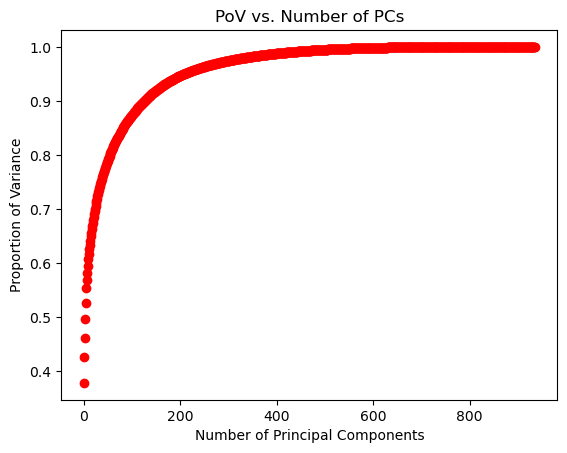

In [ ]:


def pca_pov(X):
    # scale X
    scal = StandardScaler()
    X_scaled = scal.fit_transform(X)

    # define nfeatures (ALL)
    nfeat = X.shape[1]

    # pca
    pca = PCA(n_components=nfeat, svd_solver='auto', whiten=True)
    pca.fit(X_scaled)

    # get eigenvalues
    s = pca.singular_values_ # eigenvalues corresponding to the selected components (eigenvectors)

    # calc pov
    denom = np.sum(s**2)
    pov_results = []

    for i in range(1, len(s)+1):
        num = np.sum(s[0:i]**2)
        PoV = num / denom
        pov_results.append(PoV)

    # show optimal number of components
    for p in [0.95, 0.97, 0.98, 0.99]:
        optimal_nc = np.argmax(np.array(pov_results) >= p) + 1  # +1 bc index starts at 0
        print(f"Optimal ncomponents capturing {p*100}% of Var: {optimal_nc}")


    # plot
    x = range(936)
    plt.scatter(x, pov_results, color='red')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Proportion of Variance")
    plt.title("PoV vs. Number of PCs")
    plt.show()

pca_pov(X)


In [ ]:
np.logspace(-1, -0.01, 10)

array([0.1       , 0.12882496, 0.16595869, 0.21379621, 0.27542287,
       0.35481339, 0.45708819, 0.58884366, 0.75857758, 0.97723722])

# GridSearchCV:
## Hyperparameter tuning: num components & C

In [23]:
np.logspace(-1, -0.01, 5)

array([0.1       , 0.17680722, 0.31260794, 0.55271341, 0.97723722])

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [ ]:
# Need to shuffle data bc in order of diagnosis and study site
# Gridsearch CV doesnt not directly suppoirt shuffle
X, y, group_labels = shuffle(X, y, group_labels, random_state=42)

# define objects and pipe
scaler = StandardScaler()
gkf = GroupKFold(n_splits=5)
pca = PCA()
logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', max_iter=5000) # try saga solver ?
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logreg', logreg)])

# define params to test
ncomp_test = [209, 335]
c_test = np.logspace(-1, -0.01, 5)

# create dict of params
params = {'pca__n_components': ncomp_test, 'logreg__C' : c_test}

# define and fit object estimator gridsearchcv
estimator = GridSearchCV(pipe, params, cv=gkf, return_train_score=True)
estimator.fit(X,y, groups=group_labels)


In [ ]:
print(f"Best test score: {estimator.best_score_:.4f}")
print(f"Best parameters: {estimator.best_params_}")


Best test score: 0.9431
Best parameters: {'logreg__C': 0.14962356560944334, 'pca__n_components': 335}


# Logistic Regression

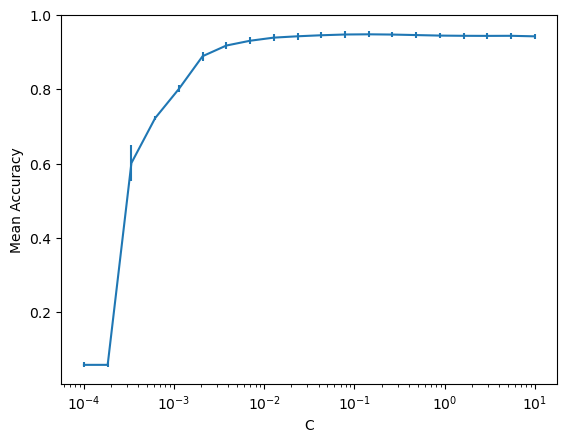

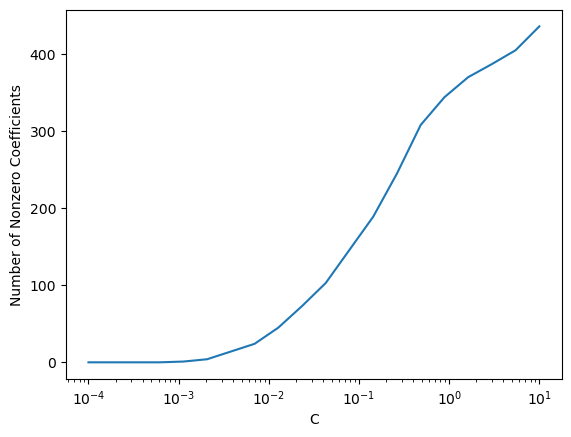

Best C value: 0.1438 with accuracy 0.9480


In [ ]:

# Initialize objects
nfold = 10
c_values = np.logspace(-1, 1, 10) # to test out: # smaller C increases regularization

# create group kfold obj
gkf = GroupKFold(n_splits=nfold, shuffle=True, random_state=42) # shuffle = True bc df compiled in order of diagnosis & site
acc = np.zeros((len(c_values), nfold)) # 20 x 10 matrix
W = np.zeros((len(c_values), X.shape[1]))  # Store mean coefficient values # 20 x 936: for every c value, store 936 coefs

for ifold, (train_index, test_index) in enumerate(gkf.split(X, y, group_labels)): # ensure groups are not split into train/test per fold
    # Get training and test data
    Xtr, ytr = X[train_index], y[train_index]
    Xts, yts = X[test_index], y[test_index]

    # Scale the data
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts)

    for ic, c in enumerate(c_values):
        # Create and fit model
        logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
        logreg.fit(Xtr1, ytr) # scaled train data

        # Predict and store accuracy
        yhat = logreg.predict(Xts1) # scaled test data
        acc[ic, ifold] = np.mean(yhat == yts) # per ith c and ith fold

        # Store mean absolute coefficients across folds
        W[ic] += np.abs(logreg.coef_[0]) / nfold

# Compute mean accuracy for each C
acc_mean = acc.mean(axis=1)
acc_se = acc.std(axis=1) / np.sqrt(nfold)

# Plot accuracy vs. C
plt.errorbar(c_values, acc_mean, yerr=acc_se)
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.show()

# Plot sparsity effect (how many nonzero coefficients)
plt.plot(c_values, np.count_nonzero(W, axis=1))
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Number of Nonzero Coefficients")
plt.show()

# Print best C value
best_c = c_values[np.argmax(acc_mean)]
print(f"Best C value: {best_c:.4f} with accuracy {np.max(acc_mean):.4f}")

In [ ]:
best_c_index = np.argmax(acc_mean)
best_c_index

12

In [ ]:
indices_non_zero = np.where(W[11,:] > 0)
indices_non_zero[0]
len((indices_non_zero)[0]) # performs best with 144 features

146

# Code Version Save

In [ ]:
# # Version 1

# # define
# groups = df_clean['Participant'].to_numpy()
# X = df_clean.iloc[:,4:].to_numpy() # identifer (window index) gets dropped
# y = np.unique(df_clean['GeneralEvent'], return_inverse=True)[1]# creates classes: 0,1,2,3,4

# # Initialize objects
# nfold = 10
# c_values = np.logspace(-4, 1, 20) # to test out: # smaller C increases regularization

# # create group kfold obj
# gkf = GroupKFold(n_splits=nfold, shuffle=True, random_state=42) # shuffle = True bc df compiled in order of diagnosis & site
# acc = np.zeros((len(c_values), nfold)) # 20 x 10 matrix
# W = np.zeros((len(c_values), X.shape[1]))  # Store mean coefficient values # 20 x 936: for every c value, store 936 coefs

# for ifold, (train_index, test_index) in enumerate(gkf.split(X, y, groups)): # ensure groups are not split into train/test per fold
#     # Get training and test data
#     Xtr, ytr = X[train_index], y[train_index]
#     Xts, yts = X[test_index], y[test_index]

#     # Scale the data
#     scal = StandardScaler()
#     Xtr1 = scal.fit_transform(Xtr)
#     Xts1 = scal.transform(Xts)

#     for ic, c in enumerate(c_values):
#         # Create and fit model
#         logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
#         logreg.fit(Xtr1, ytr) # scaled train data

#         # Predict and store accuracy
#         yhat = logreg.predict(Xts1) # scaled test data
#         acc[ic, ifold] = np.mean(yhat == yts) # per ith c and ith fold

#         # Store mean absolute coefficients across folds
#         W[ic] += np.abs(logreg.coef_[0]) / nfold

# # Compute mean accuracy for each C
# acc_mean = acc.mean(axis=1)
# acc_se = acc.std(axis=1) / np.sqrt(nfold)

# # Plot accuracy vs. C
# plt.errorbar(c_values, acc_mean, yerr=acc_se)
# plt.xscale('log')
# plt.xlabel("C")
# plt.ylabel("Mean Accuracy")
# plt.show()

# # Plot sparsity effect (how many nonzero coefficients)
# plt.plot(c_values, np.count_nonzero(W, axis=1))
# plt.xscale('log')
# plt.xlabel("C")
# plt.ylabel("Number of Nonzero Coefficients")
# plt.show()

# # Print best C value
# best_c = c_values[np.argmax(acc_mean)]
# print(f"Best C value: {best_c:.4f} with accuracy {np.max(acc_mean):.4f}")

# Best 144 Features

In [ ]:
# # which columns are associated with these non-zero weights?
# x = df_clean.iloc[:,4:]
# for col in x.columns[indices_non_zero[0]]:
#     print(col)

# Next Steps

## 1) Retry with dropping columns rather than rows
## 2) Retry with just Controls, then test accuracy on PD dataset
## 3) May need different features for next aim

# Try SVM via cross-validation

In [ ]:
#EDIT CODE

C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# Measure and print the accuracy for each C and gamma value.
#  Store the results in acc

for i, C in enumerate(C_test): # iterate over values of C
    for j, gam in enumerate(gam_test): # iterate over values of j

          # int
          svc = svm.SVC(kernel="rbf", C=C, gamma=gam)

          # fit
          svc.fit(Xtr1, ytr1)

          # predict
          yhat = svc.predict(Xts1)

            # accuracy[iC,igamma]
          acc[i,j] = np.mean(yhat==yts1)


